## Flowers Dataset Task- Accuracy 94%

<img src="https://hgtvhome.sndimg.com/content/dam/images/hgtv/fullset/2015/11/10/0/CI_Costa-Farms-Ballad-aster.jpg.rend.hgtvcom.966.644.suffix/1447169929799.jpeg" alt="Drawing" align="center" style="width: 400px;" /> 

The pictures in the dataset are divided into five classes: *daisy, dandelion, rose, sunflower, tulip*.
For each class there are about 800 photos.I have tried diffrent data augmentation techniques and other techniques to overcome overfitting.

* Pre-trained models tried:
`ResNet50`


* The model has been trained with a learning rate schedule and earlystopping.
`Learning Rate : 1e-05 to 0.0004 to 1.1178702674124267e-05 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',patience=10, verbose=1, restore_best_weights=True)`


* Data Augmentation techniques:
`RandomFlip`
`RandomRotation`


* I have tried diffrent epochs:
`100`
`50`
`30`
`35`

Hence, through these methods, I was able to achieve **94% accuracy**

## Importing the required Packages

In [1]:
# importing Python packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

*We list the directories, and check the folder for availiable types of flowers*

## Detect Hardware

In [2]:
# Attempt to initialize TPU cluster resolver

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ',tpu.master())

# Handle error if TPU is not available

except ValueError:
    tpu = None

# If TPU is available, connect to TPU cluster and initialize TPU system

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)   
    # Create TPU strategy to distribute computation across TPUs
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

# If TPU is not available, use default distribution strategy

else:
    strategy = tf.distribute.get_strategy()

# Print number of replicas (devices) available in the distributed system
    
print('Replicas: ',strategy.num_replicas_in_sync)

Replicas:  1


## Data Directories 

In [3]:
# Define the directory where the images are located
dir_ = '/kaggle/input/flowers-recognition/flowers'

# Set the desired size for the images
image_size = (180,180)

# Set the batch size for training and validation data
batch_size = 32

# Load the training dataset from the directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir_, # specify the directory where the images are located
    validation_split = 0.2, # set aside 20% of the data for validation
    subset = 'training', # specify that we want the training subset of the data
    seed = 1337, # set a seed for reproducibility
    image_size = image_size, # set the desired image size
    batch_size = batch_size # set the batch size for training data
)

# Load the validation dataset from the directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir_, # specify the directory where the images are located
    validation_split = 0.2, # set aside 20% of the data for validation
    subset = 'validation', # specify that we want the validation subset of the data
    seed = 1337, # set a seed for reproducibility
    image_size = image_size, # set the desired image size
    batch_size = batch_size # set the batch size for validation data
)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [4]:
labels = train_ds.class_names
print(labels)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


## Visualizing the Data with the labels

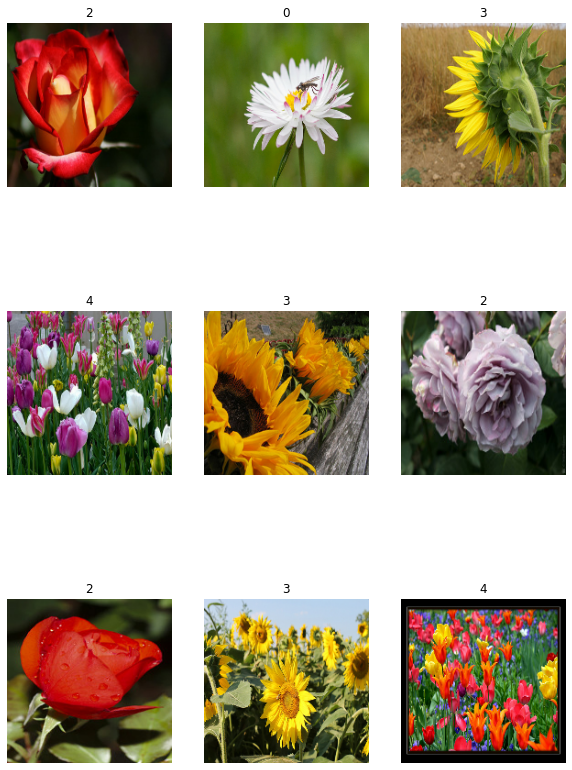

In [5]:
# Set the figure size for the plot
plt.figure(figsize=(10, 15))

# Loop through the first batch of images and labels in the train dataset
for images, label in train_ds.take(1):
    # Loop through the first 9 images in the batch
    for i in range(9):
        # Set up a subplot with 3 rows and 3 columns and plot each image with its label
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(label[i]))
        plt.axis('off')

#### Visualizing the augmented images

In [6]:
# Define a data augmentation pipeline using Keras Sequential model
data_augmentation = keras.Sequential([
    
    # Randomly flip the input images horizontally
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    
    # Randomly rotate the input images by up to 0.1 radians
    layers.experimental.preprocessing.RandomRotation(0.1),
])

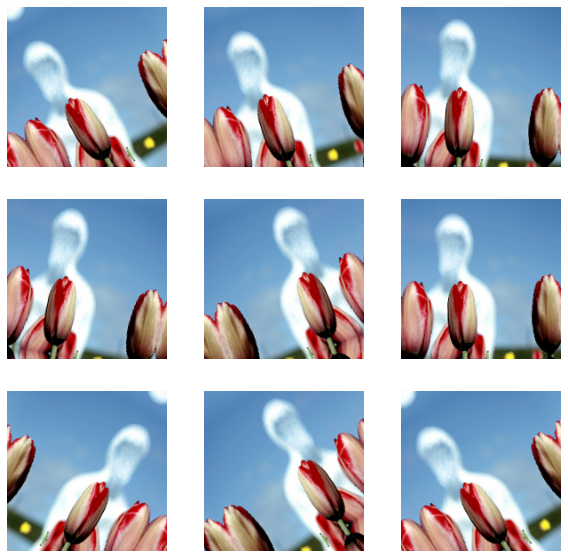

In [7]:
plt.figure(figsize=(10,10))

# Take the first batch of images and their corresponding labels from the training dataset
for images, _ in train_ds.take(1):
    
    # Apply data augmentation to the images
    for i in range(9):
        aug_images = data_augmentation(images)
        
        # Display the augmented images in a 3x3 grid
        ax = plt.subplot(3,3,i+1)
        plt.imshow(aug_images[0].numpy().astype('uint8'))
        plt.axis('off')

## Prefetching and preprocessing

Learning Rate : 1e-05 to 0.0004 to 1.1178702674124267e-05


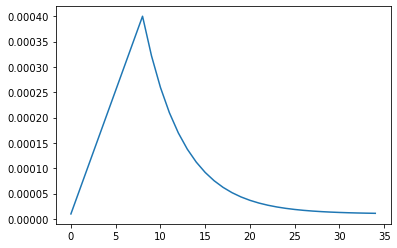

In [8]:
epochs = 35

# Define a function to adjust the learning rate based on the epoch
def learning_rate(epoch):
    # Define the initial, maximum, and minimum learning rates
    lr_start = 0.00001
    lr_max = 0.0004
    lr_min = 0.00001

    # Define the number of epochs for the learning rate ramp-up and sustain phases
    lr_rampup_epochs = 8
    lr_sustain_epochs = 0

    # Define the exponent decay factor for the learning rate
    lr_exp_decay = 0.8

    # Determine the learning rate based on the current epoch
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min

    # Return the current learning rate
    return lr

# Create a list of epoch values to plot the learning rate over time
rng = [i for i in range(epochs)]
# Create a list of learning rates corresponding to each epoch
y = [learning_rate(x) for x in rng]
# Plot the learning rate over time
plt.plot(rng,y)
# Print the initial, maximum, and final learning rates
print(f'Learning Rate : {y[0]} to {max(y)} to {y[-1]}')

In [9]:
# Prefetch the training dataset with buffer size of 32 for improved performance
train_ds = train_ds.prefetch(32)

# Prefetch the validation dataset with buffer size of 32 for improved performance
val_ds = val_ds.prefetch(32)

## Training the model

In [10]:
# Define callbacks for the model
lr_schedule = LearningRateScheduler(learning_rate, verbose=1) # Learning rate schedule callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Early stopping callback

# Create ResNet50 model
with strategy.scope():
    conv_base = tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=image_size+(3,)
    )
    conv_base.trainable = True

    # Create a sequential model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape= image_size + (3,)),
        tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
            tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
        ]),
        conv_base,
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Print summary of the model
    model.summary()

    # Compile the model with optimizer, loss and metrics
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_______________________________________________________

In [11]:
# epochs: number of times the training data is passed through the network during training
# validation_data: dataset used for validation during training
# callbacks: a list of functions called during training to modify the training process

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[lr_schedule, early_stop])
# lr_schedule: a function that schedules the learning rate during training
# early_stop: a function that stops the training process early if the validation loss doesn't improve for a certain number of epochs

Epoch 1/35

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
108/108 [==============================] - 46s 342ms/step - loss: 2.1477 - accuracy: 0.3075 - val_loss: 2.2455 - val_accuracy: 0.1587
Epoch 2/35

Epoch 00002: LearningRateScheduler reducing learning rate to 5.875e-05.
108/108 [==============================] - 18s 163ms/step - loss: 0.8059 - accuracy: 0.7236 - val_loss: 3.0808 - val_accuracy: 0.2711
Epoch 3/35

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001075.
108/108 [==============================] - 18s 161ms/step - loss: 0.3837 - accuracy: 0.8709 - val_loss: 4.4337 - val_accuracy: 0.2711
Epoch 4/35

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00015625.
108/108 [==============================] - 18s 162ms/step - loss: 0.2812 - accuracy: 0.8994 - val_loss: 2.4482 - val_accuracy: 0.3013
Epoch 5/35

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000205.
108/108 [==============================] - 18s 1

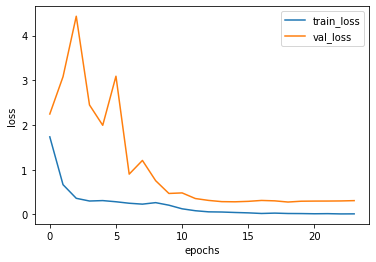

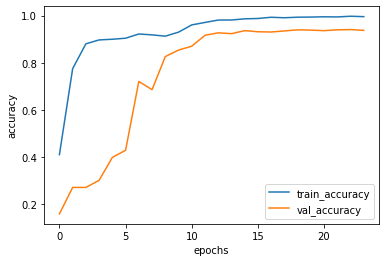

In [13]:
# epochs = 35

his = pd.DataFrame(history.history)
train_loss = his["loss"]
train_accuracy = his["accuracy"]
val_loss = his["val_loss"]
val_accuracy = his["val_accuracy"]

# figure 1
plt.figure()
plt.plot(range(24), train_loss, label='train_loss')
plt.plot(range(24), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# figure 2
plt.figure()
plt.plot(range(24), train_accuracy, label='train_accuracy')
plt.plot(range(24), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

> The model jumps a bit in the start, in order to find the learning rate initially then after 15 epochs the model starts to stabilize.

In [14]:
accuracy = model.evaluate(val_ds,verbose=1)
print(f'Loss: {accuracy[0]}')
print(f'Accuracy: {(accuracy[1] * 100):.2f} %')

27/27 [==============================] - 2s 64ms/step - loss: 0.2755 - accuracy: 0.9397
Loss: 0.275492787361145
Accuracy: 93.97 %
